# Part 2: The Fourier Transform

In [1]:
%load_ext autoreload
%autoreload 2

In [55]:
import matplotlib.pyplot as plt
import torch

from src.fourier import (
    eigendecomposition,
    fourier_transform,
    fourier_transform_operator,
    matrix_from_convolution_kernel,
    image_operator_from_sep_kernels,
    inv_fourier_transform,
    shift_operator,
)

## Part 2.1: Torus Shifts

After implementing `src.fourier.shift_operator`, we can now shift images around the torus.

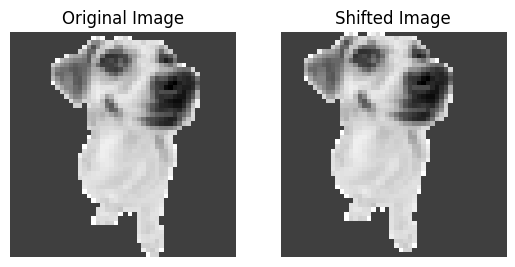

In [61]:
img = torch.tensor(plt.imread("../img/dog.png"))[..., 0]

S = shift_operator(img.shape, shift_x=4, shift_y=1)  # Experiment with these values!
shifted_img = (S @ img.flatten()).reshape(img.shape)

# Visualize the original and shifted images
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(shifted_img, cmap="gray")
plt.title("Shifted Image")
plt.axis("off")
plt.show()

In [62]:
# Test your implementation against the explicit method for shifting a matrix
shift_x = torch.randint(-100, 100, (1,)).item()
shift_y = torch.randint(-100, 100, (1,)).item()

torch.allclose(
    (shift_operator(img.shape, shift_x, shift_y) @ img.flatten()),
    torch.roll(img, [-shift_x, -shift_y], dims=(1, 0)).flatten(),
)

True

## Part 2.2: Convolutions in the Torus

Use the same machinery as above to implement generic 2D convolutions.

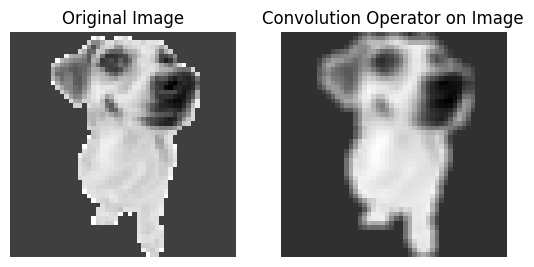

In [5]:
img = torch.tensor(plt.imread("../img/dog.png"))[..., 0]

# kernel = torch.tensor([1.0, -2.0, 1.0])  # Laplacian
kernel = torch.tensor([1, 1, 1]) / 3  # Blur
M = image_operator_from_sep_kernels(img.shape, kernel, kernel)

convolution_output = M @ img.flatten()

# Visualize the original and shifted images
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(convolution_output.reshape(img.shape), cmap="gray")
plt.title("Convolution Operator on Image")
plt.axis("off")
plt.show()

In [6]:
# Note that shifts and convolutions commute!
torch.allclose(S @ M, M @ S)

True

Note that both our 1D circulant matrices and 2D convolution operators are symmetric matrices!

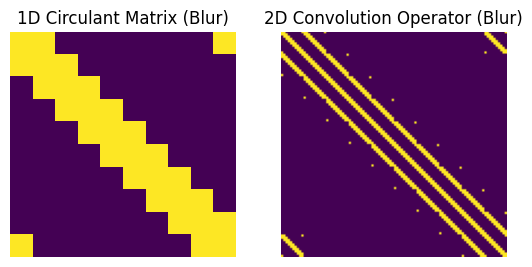

In [7]:
kernel = torch.tensor([1, 1, 1]) / 3  # Blur

circulant_check = matrix_from_convolution_kernel(kernel, 10)
M_check = image_operator_from_sep_kernels((10, 10), kernel, kernel)

plt.subplot(121)
plt.imshow(circulant_check)
plt.title("1D Circulant Matrix (Blur)")
plt.axis("off")

plt.subplot(122)
plt.imshow(M_check)
plt.title("2D Convolution Operator (Blur)")
plt.axis("off")
plt.show()

## Part 2.3: Spectral Analysis

By inspecting the eigendecomposition of the convolution operator, we can recreate the figures from the Lecture!

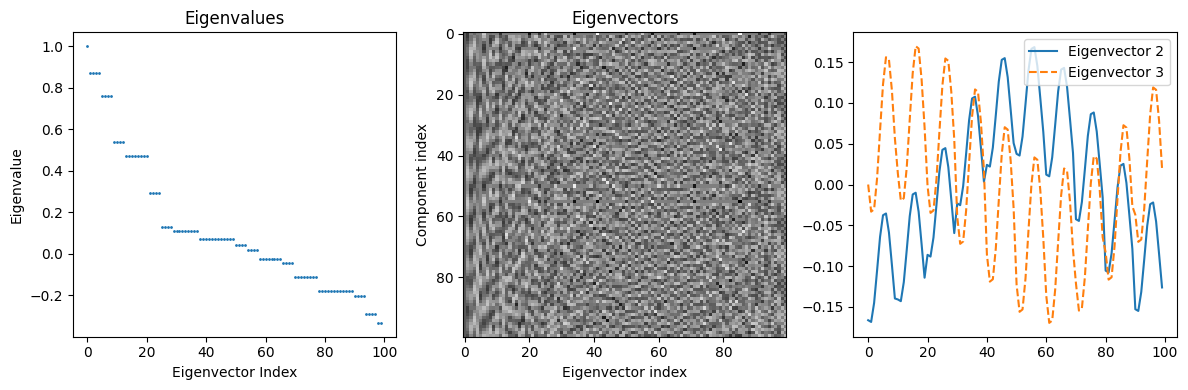

In [8]:
# DECOMPOSITION CHECK
# Note the kernel is smaller so that we can see the eigenvectors better
M = image_operator_from_sep_kernels((10, 10), kernel, kernel)
D, Q = eigendecomposition(M, descending=True)

plt.figure(figsize=(12, 4))

# Plot the eigenvalues using a scatter plot
plt.subplot(131)
plt.plot(D, "o", markersize=1)
plt.title("Eigenvalues")
plt.xlabel("Eigenvector Index")
plt.ylabel("Eigenvalue")

# Plot all the eigenvectors
plt.subplot(132)
im = plt.imshow(Q, aspect="auto", cmap="gray")
plt.title("Eigenvectors")
plt.xlabel("Eigenvector index")
plt.ylabel("Component index")

# Plot a few of the eigenvectors
plt.subplot(133)
plt.plot(D[1] * Q[:, 1], label="Eigenvector 2")
plt.plot(D[2] * Q[:, 2], linestyle="--", label="Eigenvector 3")
plt.legend()

plt.tight_layout()
plt.show()

## Part 2.4: The Fourier Transform!

Verify that your Fourier transform is correct by checking that it block-diagonalizes the convolution operator.

In [9]:
# For the convolution operator (here, M) we expect a diagonal matrix
M = image_operator_from_sep_kernels(img.shape, kernel, kernel)
_, Q = eigendecomposition(M)

M_fourier = fourier_transform_operator(M, Q)
diag_error = torch.norm(M_fourier - torch.diag(torch.diag(M_fourier)))
print("Off-diagonal norm for convolution operator:", diag_error)

Off-diagonal norm for convolution operator: tensor(2.5152e-05)


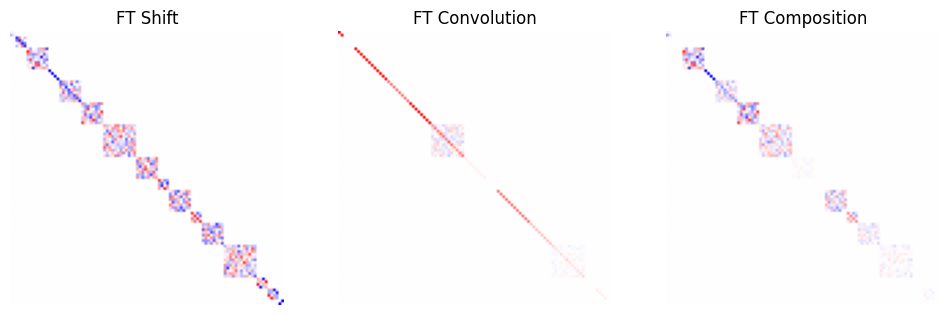

In [10]:
# For the shift operator:
S_fourier = fourier_transform_operator(S, Q)

# For another convolution:
kernel = torch.tensor([1.0, -2.0, 1.0])  # Laplacian
# kernel = torch.tensor([1, 1, 1]) / 3 # Blur
M1 = image_operator_from_sep_kernels(img.shape, kernel, kernel)
M1_fourier = fourier_transform_operator(M1, Q)

# For their composition:
M2 = S @ M1
M2_fourier = fourier_transform_operator(M2, Q)

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(S_fourier[-100:, -100:], cmap="bwr", vmin=-1, vmax=1)
plt.title("FT Shift")
plt.axis("off")

plt.subplot(132)
plt.imshow(M1_fourier[-100:, -100:], cmap="bwr", vmin=-1, vmax=1)
plt.title("FT Convolution")
plt.axis("off")

plt.subplot(133)
plt.imshow(M2_fourier[-100:, -100:], cmap="bwr", vmin=-1, vmax=1)
plt.title("FT Composition")
plt.axis("off")

plt.show()

## Part 2.5: Operators in Fourier Space

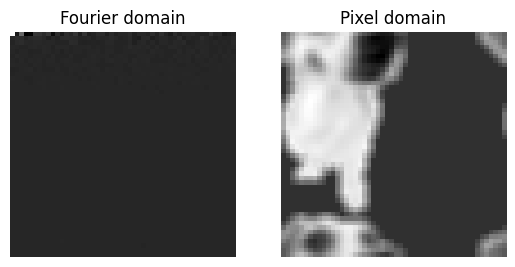

In [11]:
fourier_img = fourier_transform(img.flatten(), Q)
fourier_img = M_fourier @ S_fourier @ fourier_img  # Feel free to experiment here!
pixel_img = inv_fourier_transform(fourier_img, Q)

plt.subplot(121)
plt.imshow(fourier_img.reshape(img.shape), cmap="gray")
plt.title("Fourier domain")
plt.axis("off")

plt.subplot(122)
plt.imshow(pixel_img.reshape(img.shape), cmap="gray")
plt.title("Pixel domain")
plt.axis("off")
plt.show()

## Part 2.6: The Complex Fourier Transform (*extra credit*)

Can you convert the real-valued Fourier transform to a complex-valued Fourier transform? Recover the magnitude and phase.
